# Load Library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import math
from sklearn import preprocessing
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from operator import mul
from scipy.spatial import distance
import seaborn as sns
import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense,Multiply,Add, concatenate
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_recall_curve,roc_auc_score,precision_score

# Data Load

In [2]:
te = pd.read_csv('text_vectors.csv') # Doc2vec으로 뽑은 10차원의 Vector들
te.drop('Unnamed: 0',axis=1,inplace=True)

images = pd.read_csv('img_vecs.csv') # CNN으로 뽑은 10차원의 Vector들
images.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
label = pd.read_csv('C:/Users/user/Desktop/2022-2/관광데이터AI경진대회/open/train.csv')
Y = label['cat2']

In [4]:
data = pd.concat([te,images],axis=1)
data.reset_index(drop=True,inplace=True)


text = data.iloc[:,:250]
img = data.iloc[:,250:]

text.columns=range(0,250)
img .columns=range(0,250)

text['img=1']=0
img['img=1']=1

d_for_eda = pd.concat([text,img],axis=0)

# Original Distribution Visualize

In [5]:
x = d_for_eda.drop(['img=1'],axis=1)
y = d_for_eda['img=1']

x.reset_index(drop=True,inplace=True)

In [6]:
# PCA로 2차원으로 줄인 후, 시각화하는 함수 선언
def plot_3d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E','#00FFFF']
    markers = ['o', 's','d']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            X[y==l, 2],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [7]:
# PCA로 2차원으로 줄인 후, 시각화하는 함수 선언
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

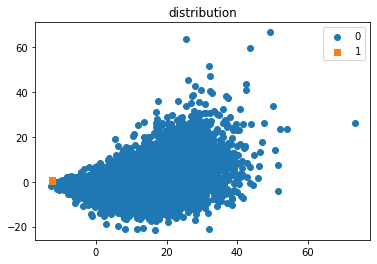

In [8]:
# 원본 데이터 분포
pca = PCA(n_components=2)
X = pca.fit_transform(x)
plot_2d_space(X, y, 'distribution')

# Vector Nomalize

In [9]:
d_for_eda.drop('img=1',axis=1,inplace=True)

norm_vec=[]
for i in tqdm(range(0,len(d_for_eda))):
    dot = d_for_eda.iloc[i:i+1,:].values
    norm = np.sqrt(np.dot(dot[0],dot[0]))
    scaled = (dot[0] / norm)
    norm_vec.append(scaled)

norm_vec = pd.DataFrame(np.array(norm_vec).reshape(len(data)*2,250))

100%|█████████████████████████████████████████████████████████████████████████| 33972/33972 [00:01<00:00, 22968.44it/s]


In [10]:
norm_vec.reset_index(drop=True,inplace=True)


text_norm = norm_vec.iloc[:len(te),:]
img_norm = norm_vec.iloc[len(te):,:]

text_norm.columns=range(0,250)
img_norm .columns=range(0,250)

# Nomalized Vector distribution Visualize

C:\Users\user\AppData\Local\Temp/ipykernel_24328/1158323884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_norm['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_24328/1158323884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_norm['img=1']=1


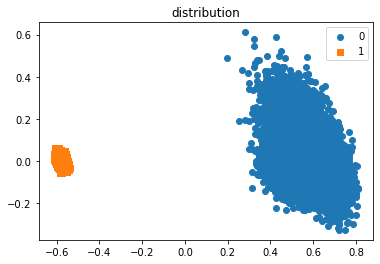

In [11]:
text_norm['img=1']=0
img_norm['img=1']=1
d_for_eda = pd.concat([text_norm,img_norm],axis=0)

x = d_for_eda.drop(['img=1'],axis=1)
y = d_for_eda['img=1']

x.reset_index(drop=True,inplace=True)

pca = PCA(n_components=2)
X = pca.fit_transform(x)
plot_2d_space(X, y, 'distribution')

# Original Data Statisitical Distribution

<AxesSubplot:ylabel='Density'>

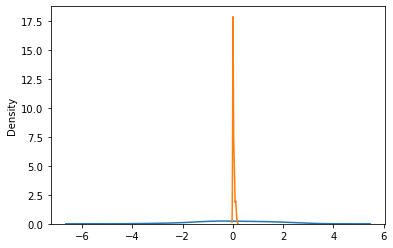

In [12]:
cv1 = te.mean()
cv2 = images.mean()

sns.kdeplot(cv1)
sns.kdeplot(cv2)

# Getting Weight and Implement Summation

In [13]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [14]:
def weighted_sum(text_vec,img_vec,text_norm,img_norm):
    # Getting Distance From Hyper Plane
    text_norm['img=1']=0
    img_norm['img=1']=1
    d_for_eda=pd.concat([text_norm,img_norm],axis=0)

    x = d_for_eda.drop('img=1',axis=1)
    y= d_for_eda['img=1']
    
    model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    clf = model.fit(x, y)
    dis = clf.decision_function(x)
    
    dis = pd.DataFrame(dis,columns=['distance_ratio'])

    x.reset_index(drop=True,inplace=True)
    
    new = pd.concat([x,dis],axis=1)
    
    new['distance_ratio'] = abs(new['distance_ratio'])
    
    new.reset_index(drop=True,inplace=True)
    images.reset_index(drop=True,inplace=True)
    
    # Find a weight with a weight sum of 1

    new_te = new.iloc[:len(text_vec),:]
    new_img = new.iloc[len(text_vec):,:]
    new_img.reset_index(drop=True,inplace=True)
    
    div = new['distance_ratio'][:len(text_vec)].values+new['distance_ratio'][len(text_vec):].values    
    weisum = new_te['distance_ratio']*( new_te['distance_ratio'] / div)+new_img['distance_ratio']*( new_img['distance_ratio'] / div)

    img_norm.reset_index(drop=True,inplace=True)
    
    real_new=pd.concat([text_vec,img_vec],axis=1)
    real_new['con_dis'] = weisum

    x = real_new.drop(['con_dis'],axis=1)
    y = weisum
    
    inputs = Input(shape=(x.shape[1],))
    # MLP
    inputs = Input(shape=(x.shape[1],))
    Selection = Dense(x.shape[1], activation='sigmoid')(inputs)
    Selection = Model(inputs=inputs, outputs=Selection)
    Extraction = Dense(x.shape[1], activation='tanh')(inputs)
    Extraction = Model(inputs=inputs, outputs=Extraction)
    x_multiply = Multiply()([inputs,Selection.output])
    Added = Add()([x_multiply, Extraction.output])
    model = Model(inputs=inputs, outputs=Added)
    
    # 모델 컴파일
    model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['MSE'])
    
    # 모델 실행
    model.fit(x, y, epochs=100, batch_size=32)

    con_scalar=model.predict(x)
    con_scalar = pd.DataFrame(con_scalar)

    soft=[]
    for i in tqdm(range(0,len(con_scalar))):
        soft.append(softmax(con_scalar.iloc[i:i+1,:].values))
    new_one = pd.DataFrame(np.array(soft).reshape(len(con_scalar),500))
    
    text_scalar = new_one.iloc[:,:250]
    img_scalar = new_one.iloc[:,250:]
    
    # Multiply the weight by the distance again
    img_scalar.reset_index(drop=True,inplace=True)
    new.reset_index(drop=True,inplace=True)
    #for i in tqdm(range(0,len(text_vec))):
    #    text_scalar.iloc[i:i+1,:250] = text_scalar.iloc[i:i+1,:250]*(new_te['distance_ratio'][i])
    #    img_scalar.iloc[i:i+1,:250] = img_scalar.iloc[i:i+1,:250]*(new_img['distance_ratio'][i])
        
    # Weighted sum
    text_sum=text_vec*text_scalar.values
    img_sum= img_vec*img_scalar.values
    text_sum.reset_index(drop=True,inplace=True)
    img_sum.reset_index(drop=True,inplace=True)
    vectors=text_sum+img_sum
    return vectors

# Train Test Split

In [15]:
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)

In [16]:
x_te_train,x_te_test,y_train,y_test = train_test_split(te,y,test_size=0.3,random_state=2022,stratify=y)
x_img_train,x_img_test,y_train,y_test= train_test_split(images,y,test_size=0.3,random_state=2022,stratify=y)

norm_te_train,norm_te_test,y_train,y_test = train_test_split(text_norm,y,test_size=0.3,random_state=2022,stratify=y)
norm_img_train,norm_img_test,y_train,y_test= train_test_split(img_norm,y,test_size=0.3,random_state=2022,stratify=y)

In [17]:
with tf.device("/device:CPU:0"):
    x_train = weighted_sum(x_te_train,x_img_train,norm_te_train,norm_img_train)
    x_test = weighted_sum(x_te_test,x_img_test,norm_te_test,norm_img_test)

Epoch 1/100
372/372 [==============================] - 1s 1ms/step - loss: 0.0958 - MSE: 0.0958
Epoch 2/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0133 - MSE: 0.0133
Epoch 3/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0122 - MSE: 0.0122
Epoch 4/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0119 - MSE: 0.0119
Epoch 5/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0117 - MSE: 0.0117
Epoch 6/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0116 - MSE: 0.0116
Epoch 7/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0115 - MSE: 0.0115
Epoch 8/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0115 - MSE: 0.0115
Epoch 9/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0115 - MSE: 0.0115
Epoch 10/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0114 - MSE: 0.0114
Epoch 11/100
372/372 [=================

372/372 [==============================] - 0s 1ms/step - loss: 0.0109 - MSE: 0.0109
Epoch 86/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0109 - MSE: 0.0109
Epoch 87/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0109 - MSE: 0.0109
Epoch 88/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0109 - MSE: 0.0109
Epoch 89/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0109 - MSE: 0.0109
Epoch 90/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0109 - MSE: 0.0109
Epoch 91/100
372/372 [==============================] - 1s 1ms/step - loss: 0.0109 - MSE: 0.0109
Epoch 92/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0109 - MSE: 0.0109
Epoch 93/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0108 - MSE: 0.0108
Epoch 94/100
372/372 [==============================] - 0s 1ms/step - loss: 0.0108 - MSE: 0.0108
Epoch 95/100
372/372 [=====================

100%|█████████████████████████████████████████████████████████████████████████| 11890/11890 [00:00<00:00, 18008.77it/s]


Epoch 1/100
160/160 [==============================] - 0s 1ms/step - loss: 0.1875 - MSE: 0.1875
Epoch 2/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0157 - MSE: 0.0157
Epoch 3/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0125 - MSE: 0.0125
Epoch 4/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0116 - MSE: 0.0116
Epoch 5/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0112 - MSE: 0.0112
Epoch 6/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0110 - MSE: 0.0110
Epoch 7/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0108 - MSE: 0.0108
Epoch 8/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0107 - MSE: 0.0107
Epoch 9/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0107 - MSE: 0.0107
Epoch 10/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0106 - MSE: 0.0106
Epoch 11/100
160/160 [=================

160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 86/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 87/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 88/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 89/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 90/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 91/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 92/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 93/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 94/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0097 - MSE: 0.0097
Epoch 95/100
160/160 [=====================

100%|███████████████████████████████████████████████████████████████████████████| 5096/5096 [00:00<00:00, 18119.25it/s]


# Visualization after combining

In [21]:
for_vis = pd.concat([x_train,x_test],axis=0)

<AxesSubplot:ylabel='Density'>

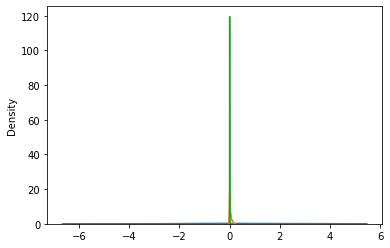

In [23]:
cv1 = te.mean()
cv2 = images.mean()
cv3 = for_vis.mean()
sns.kdeplot(cv1)
sns.kdeplot(cv2)
sns.kdeplot(cv3)

In [24]:
te['img=1']=0
images['img=1']=1
for_vis['img=1']=2

In [25]:
con = pd.concat([te,images,for_vis],axis=0)
con.reset_index(drop=True,inplace=True)
x = con.drop(['img=1'],axis=1)
y = con['img=1'].values

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


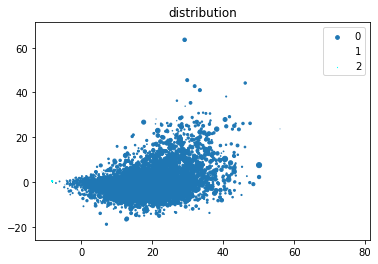

In [26]:
# 가중치 적용 후 분포 poly
pca = PCA(n_components=3)
X = pca.fit_transform(x)
plot_3d_space(X, y, 'distribution')

In [28]:
from sklearn.manifold import TSNE
# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model = TSNE(n_components=n_components)
# 2차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 2).fit_transform(x)

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


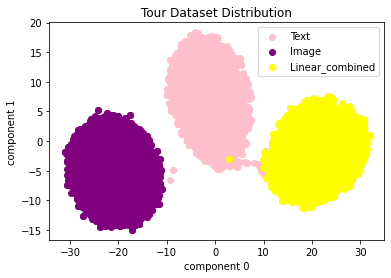

In [30]:
# class target 정보 불러오기 
tsne_df['target'] = con['img=1']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = 'Text')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'Image')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = 'Linear_combined')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.title('Tour Dataset Distribution')
plt.legend()
plt.show()

In [32]:
for_vis.drop(['img=1'],axis=1,inplace=True)

te.drop(['img=1'],axis=1,inplace=True)
images.drop(['img=1'],axis=1,inplace=True)

# Run!

In [33]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [34]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=250 , activation='relu'))
    model.add(Dense(18, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
372/372 [==============================] - 0s 645us/step - loss: 2.1592 - accuracy: 0.3452
Epoch 2/50
372/372 [==============================] - 0s 653us/step - loss: 1.6622 - accuracy: 0.5119
Epoch 3/50
372/372 [==============================] - 0s 683us/step - loss: 1.4230 - accuracy: 0.5827
Epoch 4/50
372/372 [==============================] - 0s 659us/step - loss: 1.2995 - accuracy: 0.6184
Epoch 5/50
372/372 [==============================] - 0s 664us/step - loss: 1.2244 - accuracy: 0.6355
Epoch 6/50
372/372 [==============================] - 0s 675us/step - loss: 1.1770 - accuracy: 0.6475
Epoch 7/50
372/372 [==============================] - 0s 688us/step - loss: 1.1369 - accuracy: 0.6594
Epoch 8/50
372/372 [==============================] - 0s 667us/step - loss: 1.1110 - accuracy: 0.6679
Epoch 9/50
372/372 [==============================] - 0s 672us/step - loss: 1.0871 - accuracy: 0.6741
Epoch 10/50
372/372 [==============================] - 0s 675us/step - loss: 1.068

In [35]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.45      0.26      0.33        98
           1       0.25      0.07      0.11        42
           2       0.61      0.40      0.49        42
           3       0.00      0.00      0.00         3
           4       0.68      0.62      0.65       366
           5       0.00      0.00      0.00         7
           6       0.67      0.14      0.24        28
           7       0.66      0.65      0.66       209
           8       0.57      0.53      0.55        83
           9       0.70      0.55      0.62       430
          10       0.67      0.76      0.71       471
          11       0.66      0.62      0.64       687
          12       0.76      0.90      0.82      1474
          13       0.57      0.59      0.58       473
          14       0.42      0.43      0.42       242
          15       0.57      0.70      0.63       171
          16       0.00      0.00      0.00         3
          17       0.47    

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "weighted")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

정밀도: 0.6512, 재현율: 0.6641, f1_score: 0.6641


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# DNN based approach

In [38]:
label = pd.read_csv('C:/Users/user/Desktop/2022-2/관광데이터AI경진대회/open/train.csv')
Y = label['cat2']
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)

In [39]:
te_x_train,te_test,y_train,y_test = train_test_split(te,y,test_size=0.3,random_state=2022,stratify=y)

img_x_train,img_test,y_train,y_test = train_test_split(images,y,test_size=0.3,random_state=2022,stratify=y)

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [40]:
with tf.device("/device:CPU:0"):
    
    # MLP
    inputs_te= Input(shape=(te_x_train.shape[1],))
    inputs_img= Input(shape=(img_x_train.shape[1],))
    
    text_layer = Dense(te_x_train.shape[1], activation='relu')(inputs_te)
    img_layer = Dense(img_x_train.shape[1], activation='relu')(inputs_img)
    concat = concatenate([text_layer, img_layer])
    out = Dense(18, activation='softmax')(concat)
    model = Model(inputs=[inputs_te,inputs_img], outputs=out)
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit([te_x_train,img_x_train], y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate((te_test.values,img_test.values), y_test_encoded)[1]))

Epoch 1/50
372/372 [==============================] - 1s 704us/step - loss: 1.5387 - accuracy: 0.5690
Epoch 2/50
372/372 [==============================] - 0s 718us/step - loss: 1.0170 - accuracy: 0.6950
Epoch 3/50
372/372 [==============================] - 0s 729us/step - loss: 0.8313 - accuracy: 0.7436
Epoch 4/50
372/372 [==============================] - 0s 715us/step - loss: 0.6787 - accuracy: 0.7919
Epoch 5/50
372/372 [==============================] - 0s 718us/step - loss: 0.5478 - accuracy: 0.8331
Epoch 6/50
372/372 [==============================] - 0s 710us/step - loss: 0.4261 - accuracy: 0.8744
Epoch 7/50
372/372 [==============================] - 0s 712us/step - loss: 0.3251 - accuracy: 0.9081
Epoch 8/50
372/372 [==============================] - 0s 720us/step - loss: 0.2450 - accuracy: 0.9353
Epoch 9/50
372/372 [==============================] - 0s 704us/step - loss: 0.1801 - accuracy: 0.9570
Epoch 10/50
372/372 [==============================] - 0s 715us/step - loss: 0.135

In [41]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict((te_test.values,img_test.values))
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "weighted")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.37      0.21      0.27        98
           1       0.24      0.24      0.24        42
           2       0.39      0.36      0.38        42
           3       0.00      0.00      0.00         3
           4       0.64      0.65      0.65       366
           5       0.00      0.00      0.00         7
           6       0.12      0.07      0.09        28
           7       0.62      0.64      0.63       209
           8       0.59      0.45      0.51        83
           9       0.57      0.54      0.56       430
          10       0.73      0.72      0.72       471
          11       0.64      0.64      0.64       687
          12       0.82      0.89      0.85      1474
          13       0.52      0.51      0.51       473
          14       0.38      0.37      0.38       242
          15       0.60      0.57      0.58       171
          16       0.00      0.00      0.00         3
          17       0.35    

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

# Text only

In [42]:
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)
x_train,x_test,y_train,y_test = train_test_split(te,y,test_size=0.3,random_state=2022,stratify=y)
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [43]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=250 , activation='relu'))
    model.add(Dense(18, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
372/372 [==============================] - 0s 656us/step - loss: 1.6042 - accuracy: 0.5585
Epoch 2/50
372/372 [==============================] - 0s 656us/step - loss: 1.0191 - accuracy: 0.6979
Epoch 3/50
372/372 [==============================] - 0s 659us/step - loss: 0.7579 - accuracy: 0.7773
Epoch 4/50
372/372 [==============================] - 0s 661us/step - loss: 0.5536 - accuracy: 0.8368
Epoch 5/50
372/372 [==============================] - 0s 672us/step - loss: 0.3936 - accuracy: 0.8887
Epoch 6/50
372/372 [==============================] - 0s 661us/step - loss: 0.2720 - accuracy: 0.9250
Epoch 7/50
372/372 [==============================] - 0s 667us/step - loss: 0.1816 - accuracy: 0.9571
Epoch 8/50
372/372 [==============================] - 0s 669us/step - loss: 0.1162 - accuracy: 0.9763
Epoch 9/50
372/372 [==============================] - 0s 667us/step - loss: 0.0850 - accuracy: 0.9835
Epoch 10/50
372/372 [==============================] - 0s 664us/step - loss: 0.081

In [44]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "weighted")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.32      0.20      0.25        98
           1       0.26      0.14      0.18        42
           2       0.48      0.33      0.39        42
           3       0.00      0.00      0.00         3
           4       0.65      0.63      0.64       366
           5       0.00      0.00      0.00         7
           6       0.17      0.07      0.10        28
           7       0.64      0.70      0.67       209
           8       0.47      0.43      0.45        83
           9       0.64      0.62      0.63       430
          10       0.73      0.71      0.72       471
          11       0.64      0.65      0.64       687
          12       0.79      0.89      0.84      1474
          13       0.56      0.56      0.56       473
          14       0.44      0.36      0.39       242
          15       0.62      0.61      0.62       171
          16       0.00      0.00      0.00         3
          17       0.40    

# Image only

In [45]:
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)
x_train,x_test,y_train,y_test = train_test_split(images,y,test_size=0.3,random_state=2022,stratify=y)
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [46]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=250 , activation='relu'))
    model.add(Dense(18, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
372/372 [==============================] - 0s 640us/step - loss: 2.3006 - accuracy: 0.2886
Epoch 2/50
372/372 [==============================] - 0s 656us/step - loss: 2.2159 - accuracy: 0.3093
Epoch 3/50
372/372 [==============================] - 0s 672us/step - loss: 2.1600 - accuracy: 0.3279
Epoch 4/50
372/372 [==============================] - 0s 659us/step - loss: 2.1208 - accuracy: 0.3445
Epoch 5/50
372/372 [==============================] - 0s 653us/step - loss: 2.0940 - accuracy: 0.3540
Epoch 6/50
372/372 [==============================] - 0s 653us/step - loss: 2.0763 - accuracy: 0.3611
Epoch 7/50
372/372 [==============================] - 0s 659us/step - loss: 2.0611 - accuracy: 0.3645
Epoch 8/50
372/372 [==============================] - 0s 653us/step - loss: 2.0515 - accuracy: 0.3667
Epoch 9/50
372/372 [==============================] - 0s 669us/step - loss: 2.0384 - accuracy: 0.3687
Epoch 10/50
372/372 [==============================] - 0s 651us/step - loss: 2.031

In [47]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "macro")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00        42
           3       0.00      0.00      0.00         3
           4       0.22      0.03      0.05       366
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00        28
           7       0.08      0.01      0.02       209
           8       0.50      0.01      0.02        83
           9       0.29      0.08      0.12       430
          10       0.30      0.44      0.35       471
          11       0.38      0.39      0.39       687
          12       0.43      0.73      0.54      1474
          13       0.26      0.45      0.33       473
          14       0.00      0.00      0.00       242
          15       0.24      0.20      0.22       171
          16       0.00      0.00      0.00         3
          17       0.08    

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

# Concatanation Approach

In [48]:
train = pd.concat([te,images],axis=1)
x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.3,random_state=2022,stratify=y)

In [50]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=500 , activation='relu'))
    model.add(Dense(18, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
372/372 [==============================] - 0s 750us/step - loss: 1.5041 - accuracy: 0.5833
Epoch 2/50
372/372 [==============================] - 0s 777us/step - loss: 0.9510 - accuracy: 0.7072
Epoch 3/50
372/372 [==============================] - 0s 796us/step - loss: 0.7191 - accuracy: 0.7785
Epoch 4/50
372/372 [==============================] - 0s 780us/step - loss: 0.5371 - accuracy: 0.8400
Epoch 5/50
372/372 [==============================] - 0s 763us/step - loss: 0.3806 - accuracy: 0.8892
Epoch 6/50
372/372 [==============================] - 0s 758us/step - loss: 0.2705 - accuracy: 0.9251
Epoch 7/50
372/372 [==============================] - 0s 758us/step - loss: 0.1824 - accuracy: 0.9562
Epoch 8/50
372/372 [==============================] - 0s 755us/step - loss: 0.1214 - accuracy: 0.9735
Epoch 9/50
372/372 [==============================] - 0s 766us/step - loss: 0.0951 - accuracy: 0.9792
Epoch 10/50
372/372 [==============================] - 0s 774us/step - loss: 0.106

In [51]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "macro")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.31      0.32      0.31        98
           1       0.17      0.19      0.18        42
           2       0.45      0.40      0.43        42
           3       0.00      0.00      0.00         3
           4       0.69      0.52      0.59       366
           5       0.00      0.00      0.00         7
           6       0.23      0.11      0.15        28
           7       0.66      0.67      0.66       209
           8       0.43      0.41      0.42        83
           9       0.54      0.59      0.56       430
          10       0.77      0.69      0.73       471
          11       0.63      0.66      0.65       687
          12       0.83      0.85      0.84      1474
          13       0.50      0.57      0.53       473
          14       0.35      0.44      0.39       242
          15       0.61      0.55      0.58       171
          16       0.00      0.00      0.00         3
          17       0.37    

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

# Element Wise Sum

In [52]:
train = te+images
x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.3,random_state=2022,stratify=y)

In [53]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=250 , activation='relu'))
    model.add(Dense(18, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
372/372 [==============================] - 0s 637us/step - loss: 1.6019 - accuracy: 0.5566
Epoch 2/50
372/372 [==============================] - 0s 680us/step - loss: 1.0117 - accuracy: 0.6959
Epoch 3/50
372/372 [==============================] - 0s 656us/step - loss: 0.7548 - accuracy: 0.7727
Epoch 4/50
372/372 [==============================] - 0s 659us/step - loss: 0.5404 - accuracy: 0.8414
Epoch 5/50
372/372 [==============================] - 0s 651us/step - loss: 0.3762 - accuracy: 0.8951
Epoch 6/50
372/372 [==============================] - 0s 651us/step - loss: 0.2672 - accuracy: 0.9288
Epoch 7/50
372/372 [==============================] - 0s 667us/step - loss: 0.1892 - accuracy: 0.9544
Epoch 8/50
372/372 [==============================] - 0s 651us/step - loss: 0.1245 - accuracy: 0.9730
Epoch 9/50
372/372 [==============================] - 0s 661us/step - loss: 0.0854 - accuracy: 0.9843
Epoch 10/50
372/372 [==============================] - 0s 659us/step - loss: 0.068

In [54]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "macro")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.39      0.26      0.31        98
           1       0.18      0.14      0.16        42
           2       0.33      0.31      0.32        42
           3       0.00      0.00      0.00         3
           4       0.63      0.65      0.64       366
           5       0.00      0.00      0.00         7
           6       0.36      0.18      0.24        28
           7       0.64      0.63      0.64       209
           8       0.49      0.46      0.47        83
           9       0.61      0.60      0.61       430
          10       0.74      0.73      0.74       471
          11       0.66      0.63      0.65       687
          12       0.79      0.89      0.84      1474
          13       0.55      0.54      0.55       473
          14       0.39      0.35      0.37       242
          15       0.60      0.60      0.60       171
          16       0.00      0.00      0.00         3
          17       0.36    

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

# Tensor Fusion Network

In [37]:
te['add1']=1
images['add1']=1

In [38]:
tfn=[]
for i in tqdm(range(0,len(te))):
    tfn.append(np.outer(te.iloc[i:i+1,:].values,images.iloc[i:i+1,:].values))

100%|██████████████████████████████████████████████████████████████████████████| 16986/16986 [00:05<00:00, 2991.12it/s]


In [50]:
tfn = np.array(tfn).reshape(16986,251*251)

tfn_df = pd.DataFrame(tfn)
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)
x_train,x_test,y_train,y_test = train_test_split(tfn_df,y,test_size=0.3,random_state=2022,stratify=y)
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [47]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=63001 , activation='relu'))
    model.add(Dense(18, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
372/372 [==============================] - 59s 157ms/step - loss: 1.5502 - accuracy: 0.5775
Epoch 2/50
372/372 [==============================] - 53s 143ms/step - loss: 1.0278 - accuracy: 0.6903
Epoch 3/50
372/372 [==============================] - 52s 140ms/step - loss: 0.8064 - accuracy: 0.7533
Epoch 4/50
372/372 [==============================] - 53s 141ms/step - loss: 0.6422 - accuracy: 0.7997
Epoch 5/50
372/372 [==============================] - 53s 142ms/step - loss: 0.4934 - accuracy: 0.8429
Epoch 6/50
372/372 [==============================] - 53s 141ms/step - loss: 0.3951 - accuracy: 0.8739
Epoch 7/50
372/372 [==============================] - 52s 140ms/step - loss: 0.3183 - accuracy: 0.8997
Epoch 8/50
372/372 [==============================] - 52s 140ms/step - loss: 0.2668 - accuracy: 0.9138
Epoch 9/50
372/372 [==============================] - 52s 141ms/step - loss: 0.2020 - accuracy: 0.9337
Epoch 10/50
372/372 [==============================] - 53s 142ms/step - l

In [48]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "weighted")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.25      0.14      0.18        98
           1       0.28      0.26      0.27        42
           2       0.28      0.31      0.29        42
           3       0.00      0.00      0.00         3
           4       0.50      0.67      0.57       366
           5       0.00      0.00      0.00         7
           6       0.17      0.11      0.13        28
           7       0.47      0.70      0.57       209
           8       0.40      0.45      0.42        83
           9       0.60      0.57      0.59       430
          10       0.75      0.65      0.70       471
          11       0.59      0.67      0.63       687
          12       0.85      0.77      0.81      1474
          13       0.52      0.61      0.56       473
          14       0.43      0.37      0.40       242
          15       0.60      0.58      0.59       171
          16       0.00      0.00      0.00         3
          17       0.37    

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U